In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from visualization_utils import visualization_utils_images
from keras.layers import Dense, Flatten, Input, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

C:\Users\danie\JupyterProjects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [37]:
# We will be using two pretrained models, we will use the VGG16 model, that was trained on the imagenet dataset, to extract features from
# our images, we will then use the BLIP transformer to caption these images.

# Define configuration
batch_size = 32
num_epochs = 8
img_row, img_col = 224, 224 # VGG16 was trained on images of size 224 x 224, so this is what we should rescale our images to.
input_shape = (img_row, img_col, 3)

In [4]:
import tarfile
import os
import urllib.request
import shutil

# url of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

print(f"Current kernal directory: {os.getcwd()}")

# The name we want to give the tar file
tar_filename = "aircraft_damage_dataset_v1.tar"

# The folder where the contents of the tar file will be extracted into. We don't control this name,
# it is made by the creator of the tar file.
extracted_folder = "aircraft_damage_dataset_v1"

# Go to the provided url and download the tar file, and name it aircraft_damage_dataset_v1.tar
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will now begin...")

# If the extracted file already exists, then remove the existing file
if os.path.exists(extracted_folder): # This path will be relative to the current directory.
    print(f"file {extracted_folder} already exists. removing {extracted_folder}... ")

    # Remove the folder.
    shutil.rmtree(extracted_folder)
    print(f"File {extracted_folder} removed. ")

# Extract the file contents
with tarfile.open(tar_filename, "r") as tar:    # Open the tar file in read mode
    tar.extractall(filter="data")    # Since no path argument is passed, it will extract the contents into the current directory
    print(f"Extracted {extracted_folder} successfully.")

# Remove the tar file after extraction
print(f"Removing {tar_filename}...")
os.remove(tar_filename)
print(f"{tar_filename} removed.")

Current kernal directory: C:\Users\danie\JupyterProjects\VGG16-BLIP-Damage-Detection
Downloaded aircraft_damage_dataset_v1.tar. Extraction will now begin...
file aircraft_damage_dataset_v1 already exists. removing aircraft_damage_dataset_v1... 
File aircraft_damage_dataset_v1 removed. 
Extracted aircraft_damage_dataset_v1 successfully.
Removing aircraft_damage_dataset_v1.tar...
aircraft_damage_dataset_v1.tar removed.


In [5]:
# We're currently in \Users\danie\JupyterProject. To get to the train, test, and validation directories, we have to go into the
# extracted folder
# os.path.join concatenates the paths correctly depending on the operating system we're using.
# These variables contain the complete file path to our data folders.
train_dir = os.path.join(extracted_folder, "train")
test_dir = os.path.join(extracted_folder, "test")
valid_dir = os.path.join(extracted_folder, "valid")

In [6]:
# This creates ImageDataGenerator objects, we're making 'blueprints' for what we want to happen when we call the flow_from_directory function next.
# We can also use the ImageDataGenerator class for data augmentation, for instance we can create new datapoints by flipping, zooming into, and rotating
# images already present in our data.
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)
valid_data_gen = ImageDataGenerator(rescale=1./255)

In [7]:
# Next, we use the flow_from_directory function. This function will
# go to the directory "train_dir", load a batch of images, apply the rules from our blueprint
# (i.e., in our case normalize them), rescale the images to 224 x 224 for VGG16,
train_generator = train_data_gen.flow_from_directory(
    train_dir, # The directory the function goes to look for images.
    target_size=(img_row, img_col), # Rescale to a size VGG16 expects
    batch_size=batch_size, # The number of images we collect at a time.
    seed=seed_value,  # Ensure random processes, like shuffling, are reproducible
    class_mode='binary', # Binary classification since we have 2 classes, 'dent' or 'crack'
    shuffle=True # shuffles the order of the training images before each full pass through the training data (epoch)
)
# The generator expects the train directory, train_dir, to have subcategories. The flow_from_directory method
# will assign the training examples in each subcategory to a class by alphanumerical order. For example, we have the
# sub categories crack and dent, c comes before d, therefore training examples in directory crack will have class label 0,
# and dent will have class label 1. We can confirm this by printing the class indices.
print(train_generator.class_indices)

Found 300 images belonging to 2 classes.
{'crack': 0, 'dent': 1}


In [8]:
# Create a validation set generator that loads images from the validation directory, normalizes it, resizes them to a size
# VGG16 expects, groups them into batches, assigns 0 and 1 to the subdirectories, and shuffles the images after
# each epoch.
valid_generator = valid_data_gen.flow_from_directory(
    valid_dir,
    target_size=(img_row, img_col),
    batch_size=batch_size,
    seed=seed_value,
    class_mode='binary',
    shuffle=True
)

# Create a validation set generator that loads images from the validation directory, normalizes it, resizes them to a size
# VGG16 expects, groups them into batches, assigns 0 and 1 to the subdirectories, and shuffles the images after
# each epoch.
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(img_row, img_col),
    batch_size=batch_size,
    seed=seed_value,
    class_mode='binary',
    shuffle=True
)

Found 96 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [9]:
# Load the VGG16 model
base_model = VGG16(
    weights="imagenet", # Loads the model with the weights it learned during the ImageNet competition
    include_top=False, # This gives us the feature extraction part of the VGG16 model, not the classifier part.
    input_shape=(img_row, img_col, 3))

# A CNN can be thought of as two parts, the base and the top. The base are the convolutional and pooling layers,
# they're responsible for feature extraction, identifying simple features like edges and corners in the early layers,
# and eventually objects like an eye or a wheel in the later layers. The top is the "conventional" portion of the CNN,
# where we use the dense, fully connected layers to take the list of features found from the base and make a final
# classification based on them. Since the top for the VGG16 model was configured to classify 1000 classes, this
# is not what we want, hence why we remove it here.

In [10]:
# returns the output of the last layer of the base
output = base_model.layers[-1].output

# Since the output of the last layer is a multidimensional tensor, we pass it through a
# flatten layer to flatten it into a 1d vector that the conventional portion expects
output = Flatten()(output)

# We build a new model that starts at the input of the original base model, and ends at the
# new flattened layer we just created.
base_model = Model(inputs=base_model.input, outputs=output)

# Freeze the layers of the base portion to preserve their pretrained knowledge
for layer in base_model.layers:
    layer.trainable = False

In [38]:
# Builds the top
model = Sequential([
    base_model, # Build on top of the base model
    Dense(512, activation='relu'),
    Dropout(0.3), # Takes the activations from the previous layer and sets 30% of them to 0. Helping to prevent overfitting.
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Define the optimizer, loss, and evaluation metrics.
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train model
model.fit(train_generator, epochs=num_epochs, verbose=2, validation_data=valid_generator)

Epoch 1/8
10/10 - 22s - 2s/step - accuracy: 0.4700 - loss: 1.7230 - val_accuracy: 0.5104 - val_loss: 0.8858
Epoch 2/8
10/10 - 21s - 2s/step - accuracy: 0.6133 - loss: 1.0330 - val_accuracy: 0.6562 - val_loss: 0.5961
Epoch 3/8
10/10 - 21s - 2s/step - accuracy: 0.6400 - loss: 0.7408 - val_accuracy: 0.6146 - val_loss: 0.6045
Epoch 4/8
10/10 - 21s - 2s/step - accuracy: 0.7633 - loss: 0.5395 - val_accuracy: 0.6875 - val_loss: 0.5154
Epoch 5/8
10/10 - 21s - 2s/step - accuracy: 0.8333 - loss: 0.3887 - val_accuracy: 0.6875 - val_loss: 0.5322
Epoch 6/8
10/10 - 21s - 2s/step - accuracy: 0.9067 - loss: 0.2335 - val_accuracy: 0.7188 - val_loss: 0.5175
Epoch 7/8
10/10 - 21s - 2s/step - accuracy: 0.9000 - loss: 0.2210 - val_accuracy: 0.7396 - val_loss: 0.4615
Epoch 8/8
10/10 - 21s - 2s/step - accuracy: 0.9567 - loss: 0.1342 - val_accuracy: 0.7396 - val_loss: 0.4549


In [39]:
# The model.fit() function returns a history object which holds the values of our train and validation loss and evaluation
# metrics at the end of each epoch. We can access this dictionary using .history on the history object, we can then use these
# values for plotting.
train_history = model.history.history

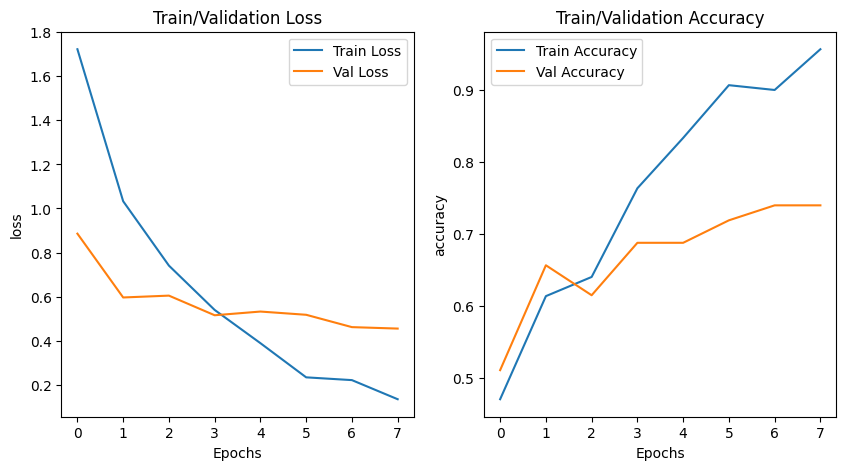

In [40]:
# Define number of plots and plot size
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Metrics we want to plot
metrics_to_plot = ["loss", "accuracy"]

for i, metric in enumerate(metrics_to_plot):
    # Plot the loss for the first iteration, then the accuracy on the second
    ax[i].plot(train_history[metric], label=f"Train {metric.capitalize()}")
    ax[i].plot(train_history[f"val_{metric}"], label=f"Val {metric.capitalize()}")

    # Define the title and x,y labels for each graph
    ax[i].set_title(f"Train/Validation {metric.capitalize()}")
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metric)

    # Display the legends for each graph
    ax[i].legend()

# Show graphs
plt.show()

In [41]:
# Evaluate the trained model on the test dataset. The steps parameter tells the model.evaluate function how many
# batches to run to do a full pass of the test dataset. The test_generator provides a pair (images, true labels)
# for each batch. When we run the function it feeds the images into the model to get the predictions, which it then
# compares to the true labels, which it will use to calculate the loss and accuracy, it repeats this for all batches
# and takes the average loss and accuracy as the final performance metrics.
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8125 - loss: 0.7333
Test loss: 0.7333, Test accuracy: 0.8125


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


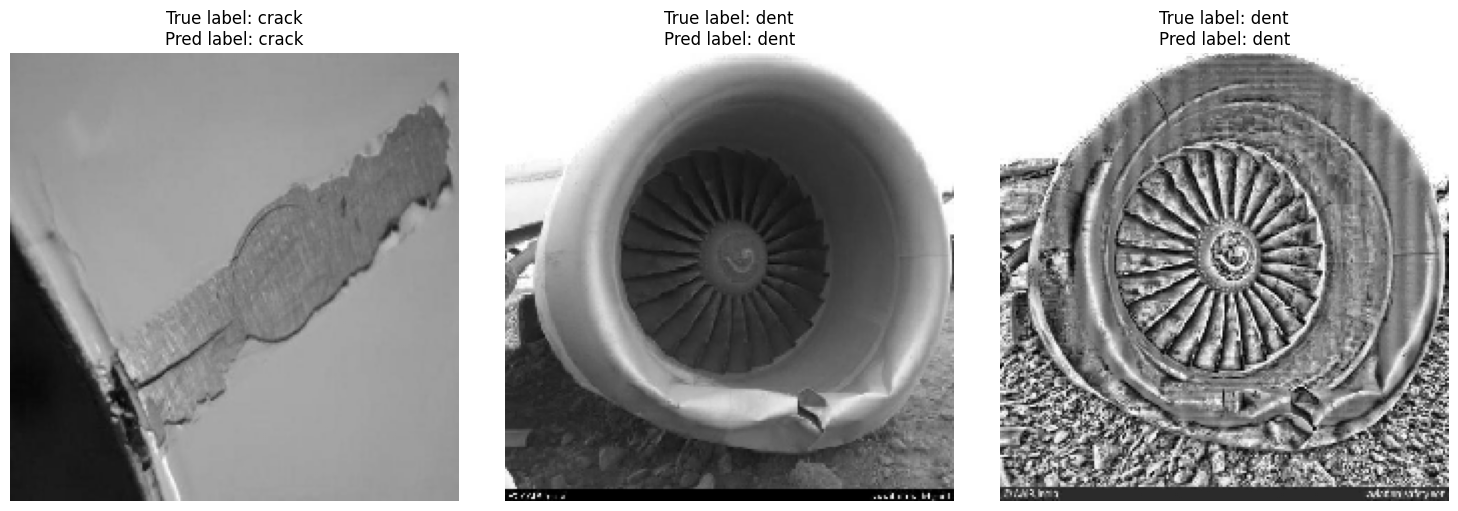

In [44]:
# We can have a look at some images and compare what the model predicted and what the true value was
visualizer = visualization_utils_images()
visualizer.test_model_on_image(test_generator=test_generator, model=model, num_to_plot=3)